In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba.typed import List

from neurolib.models.wc import WCModel
from neurolib.control.optimal_control import cost_functions

%load_ext autoreload
%autoreload 2

%load_ext line_profiler

def get_xs():
    xs_begin = np.concatenate((model.params["exc_init"], model.params["inh_init"]), axis=1)[
        :, :, np.newaxis
    ]
    xs = np.concatenate(
        (
            xs_begin,
            np.stack((model.exc, model.inh), axis=1),
        ),
        axis=2,
    )

    return xs

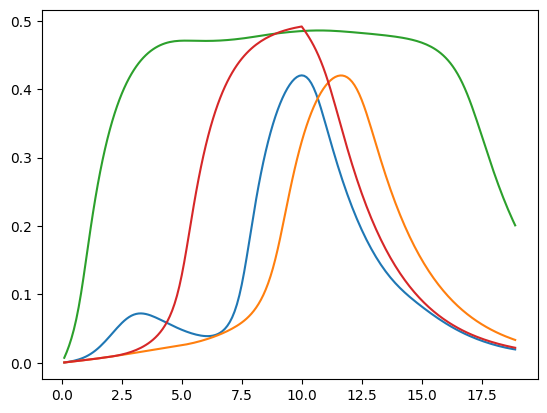

[[-0.05604241  0.        ]
 [-0.03703617  0.        ]
 [-0.05581303  0.        ]
 [-0.00696249  0.        ]]


In [2]:
N = 4
duration = 6.*np.pi
dt = 0.1
period = 2.*np.pi
target_period = period

model = WCModel(Cmat=np.ones((N,N)), Dmat=np.ones((N,N)))
model.params['duration'] = duration
model.params.dt = dt
model.params.K_gl = 1.
model.params.exc_init = np.zeros((N,1))
model.params.inh_init = np.zeros((N,1))

input = np.zeros((N,2,1+int(duration/dt)+1))
input[0,0,:] = np.sin(np.arange(0,duration+dt,dt))
input[2,0,:] = 2. + 0.2*np.sin(2.*np.pi*np.arange(0,duration+dt,dt)/period)
input[3,0,20:100] = np.linspace(0,3,80)

model.params.exc_ext = input[:,0,:]

model.run()
state = get_xs()

#state = np.zeros((N,1,1+int(duration/dt)))
#state[0,0,:] = np.sin(np.arange(0,np.around(duration+dt,1),dt))
#state[1,0,:] = np.sin(np.arange(0,duration+dt,dt))

for n in range(N):
    plt.plot(model.t, state[n,0,1:])

plt.show()

cost_matrix = np.zeros((N,2))
cost_matrix[:,0] = 1
interval = List([0,int(duration/dt)])

fcost = cost_functions.fourier_cost(state, dt, target_period, cost_matrix, interval)
print(fcost)

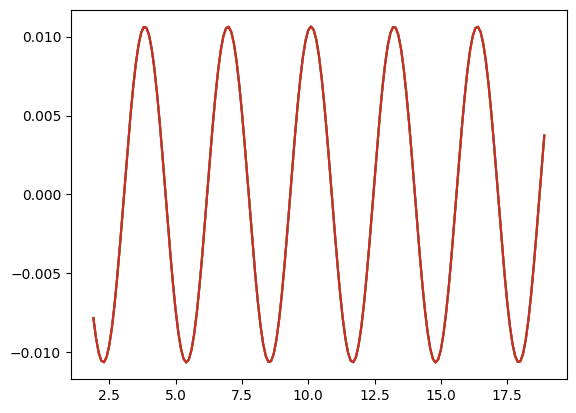

In [3]:
der_fourier = cost_functions.derivative_fourier_cost_sync(state, dt, np.pi, cost_matrix, interval)
for n in range(N):
    plt.plot(model.t[int(0.1*duration/dt):], der_fourier[n,0,1+int(0.1*duration/dt):])

plt.show()